## 0) Dependencias

Instalar las librerías necesarias

In [ ]:
#%pip install torch torchvision faiss-cpu pillow numpy matplotlib tqdm

In [16]:
import os
from tqdm import tqdm

import torch
from torchvision import models, transforms

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import faiss
import pickle

## 1) Configuración

Definir nombres de configuración

In [3]:
DATASET_DIR         = "images"  # carpeta con imágenes de ropa
EMBEDDINGS_FILE     = "embeddings.npy"
FILENAMES_FILE      = "filenames.pkl"
FAISS_INDEX_FILE    = "faiss_index.bin"

Configurar dispositivo disponible (GPU o CPU)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


Mostrar backend detectado

In [ ]:
print(f"PyTorch versión: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU detectada: {torch.cuda.get_device_name(0)}")

PyTorch versión: 2.5.1+cu121
CUDA disponible: True
GPU detectada: NVIDIA GeForce GTX 1050 Ti


## 2) Generar embeddings

In [5]:
def load_model():
    """Cargar modelo Resnet50"""
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    model = torch.nn.Sequential(*list(model.children())[:-1])  # Quitar capa final
    model.to(device)  # Enviar modelo a GPU o CPU
    model.eval()
    
    return model

In [10]:
MODELO = load_model()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Carlos/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:59<00:00, 1.74MB/s]


Transformaciones a aplicar a las imágenes (Redimensionamiento y normalización)

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [7]:
def get_embedding(model, image_path):
    """Obtener embedding"""
    image = Image.open(image_path).convert("RGB")
    tensor = transform(image).unsqueeze(0).to(device)  # Enviar imagen a GPU
    
    with torch.no_grad():
        embedding = model(tensor).squeeze().cpu().numpy()  # Regresar a CPU antes de numpy
    
    return embedding / np.linalg.norm(embedding)

Generar embeddings para todo el dataset

In [ ]:
def build_embeddings(model, dataset_dir):
    embeddings = []
    filenames = []

    for fname in tqdm(os.listdir(dataset_dir)):
        if fname.lower().endswith((".jpg", ".png", ".jpeg")):
            path = os.path.join(dataset_dir, fname)
            emb = get_embedding(model, path)
            embeddings.append(emb)
            filenames.append(fname)

    embeddings = np.array(embeddings).astype("float32")

    # Guardar embedding
    np.save(EMBEDDINGS_FILE, embeddings)
    with open(FILENAMES_FILE, "wb") as f:
        pickle.dump(filenames, f)

    return embeddings, filenames

In [11]:
embeddings, filenames = build_embeddings(MODELO, DATASET_DIR)

100%|██████████| 44441/44441 [17:54<00:00, 41.34it/s]


## 3) Crear el índice FAISS

In [12]:
def build_faiss_index(embeddings):
    dim = embeddings.shape[1]
    index = faiss.IndexFlatL2(dim)  # Índice simple de similitud L2
    index.add(embeddings)
    faiss.write_index(index, FAISS_INDEX_FILE)
    
    return index

Cargar los embeddings del dataset

In [13]:
build_faiss_index(embeddings)

<faiss.swigfaiss_avx2.IndexFlatL2; proxy of <Swig Object of type 'faiss::IndexFlatL2 *' at 0x000002800D9E3600> >

## 4) Búsqueda de imágenes similares

In [14]:
def search_similar(model, query_image_path, top_k=5):
    # Cargar nombres e índice FAISS
    with open(FILENAMES_FILE, "rb") as f:
        filenames = pickle.load(f)
    index = faiss.read_index(FAISS_INDEX_FILE)

    # Generar embedding de la imagen query (float32, normalizado)
    query_emb = get_embedding(model, query_image_path).astype("float32").reshape(1, -1)

    # Buscar k más cercanos
    distances, indices = index.search(query_emb, top_k)

    print("Resultados más similares:")
    for rank, idx in enumerate(indices[0]):
        print(f"{rank+1}. {filenames[idx]}  (distancia={distances[0][rank]:.4f})")

    return [filenames[i] for i in indices[0]]

Hacer pruebas

In [15]:
query_path = "images_test/prueba_1.jpg"
results = search_similar(MODELO, query_path, top_k=5)

Resultados más similares:
1. 6668.jpg  (distancia=0.0000)
2. 6740.jpg  (distancia=0.2778)
3. 6639.jpg  (distancia=0.2987)
4. 4550.jpg  (distancia=0.3004)
5. 5927.jpg  (distancia=0.3014)


## 5) Visualizar resultados

In [17]:
def show_results(query_image_path, result_filenames):
    plt.figure(figsize=(15, 4))
    query_img = Image.open(query_image_path)
    plt.subplot(1, len(result_filenames) + 1, 1)
    plt.imshow(query_img)
    plt.title("Query")
    plt.axis("off")

    for i, fname in enumerate(result_filenames):
        img = Image.open(os.path.join(DATASET_DIR, fname))
        plt.subplot(1, len(result_filenames) + 1, i + 2)
        plt.imshow(img)
        plt.title(f"Top {i+1}")
        plt.axis("off")
    plt.show()

Resultados más similares:
1. 6668.jpg  (distancia=0.0000)
2. 6740.jpg  (distancia=0.2778)
3. 6639.jpg  (distancia=0.2987)
4. 4550.jpg  (distancia=0.3004)
5. 5927.jpg  (distancia=0.3014)


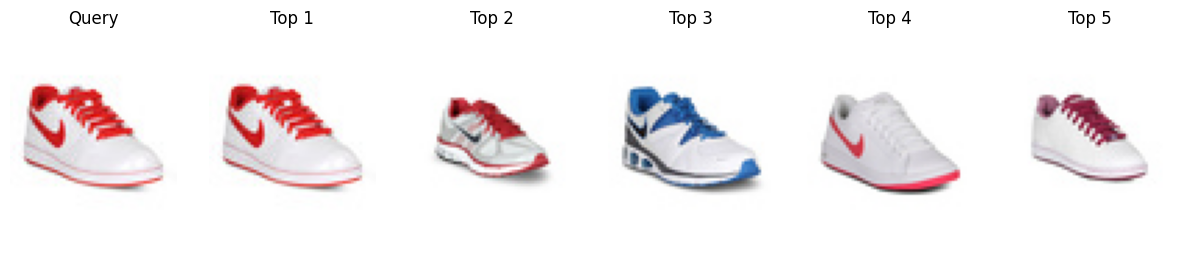

In [18]:
query_path = "images_test/prueba_1.jpg"
results = search_similar(MODELO, query_path, top_k=5)
show_results(query_path, results)

Resultados más similares:
1. 6668.jpg  (distancia=0.3883)
2. 4561.jpg  (distancia=0.4946)
3. 4558.jpg  (distancia=0.5161)
4. 46804.jpg  (distancia=0.5282)
5. 5927.jpg  (distancia=0.5334)


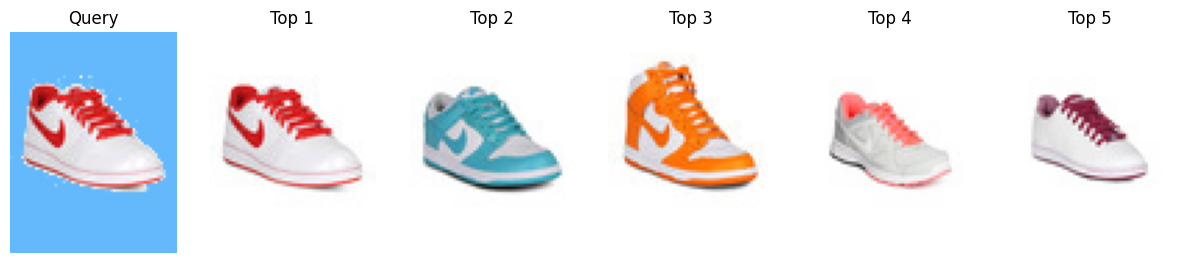

In [21]:
query_path = "images_test/prueba_2.jpg"
results = search_similar(MODELO, query_path, top_k=5)
show_results(query_path, results)

Resultados más similares:
1. 23842.jpg  (distancia=0.4896)
2. 54534.jpg  (distancia=0.5148)
3. 24421.jpg  (distancia=0.5179)
4. 3457.jpg  (distancia=0.5211)
5. 22697.jpg  (distancia=0.5245)


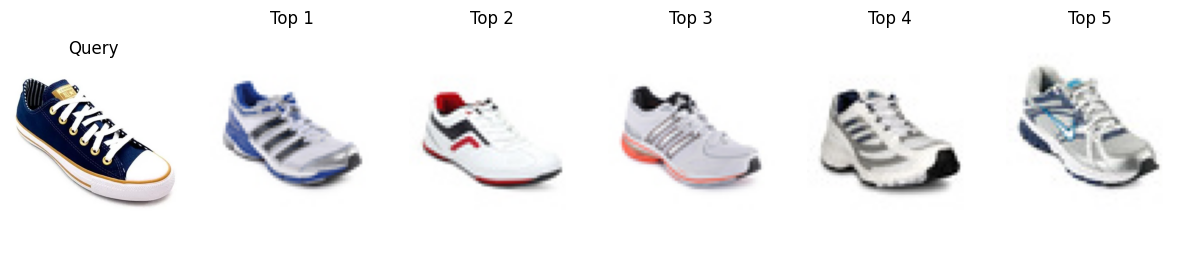

In [20]:
query_path = "images_test/prueba_3.jpg"
results = search_similar(MODELO, query_path, top_k=5)
show_results(query_path, results)

Resultados más similares:
1. 1538.jpg  (distancia=0.0000)
2. 1671.jpg  (distancia=0.1344)
3. 6041.jpg  (distancia=0.1721)
4. 16437.jpg  (distancia=0.1735)
5. 3192.jpg  (distancia=0.1759)


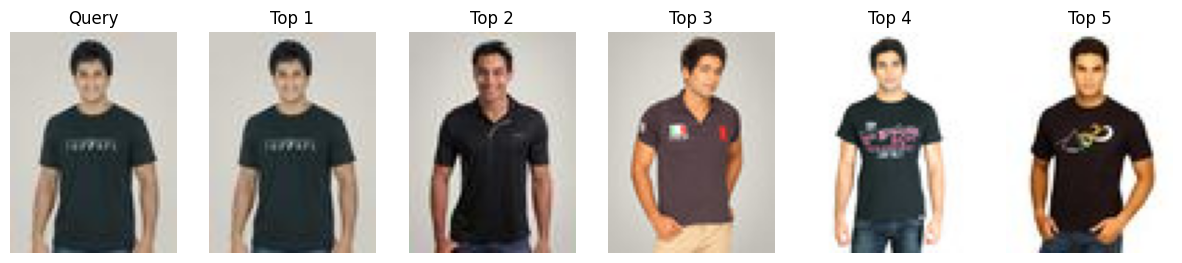

In [22]:
query_path = "images_test/prueba_4.jpg"
results = search_similar(MODELO, query_path, top_k=5)
show_results(query_path, results)